## Uncertainty analysis in `curlew`

Since curlew uses Random Fourier Features, we can generate an ensemble of predictions by changing the seed of the random number generator. This can help us get an idea of the epistemic uncertainty within our interpolations.

In [1]:
# Import the necessary libraries
import curlew
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import cmasher as cmr
import torch
import random
import joblib

# The necessary sub-modules
from curlew import GeoModel
from curlew.geology import strati, fold
from curlew.fields.analytical import ALF

# Change this to "cpu" if you don't have CUDA cores
curlew.device = 'cuda'
curlew.dtype = torch.float32

In [ ]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../Utils/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-2, 2]

# Curlew colormap
import matplotlib.colors as mcolors

# Define the colors extracted manually from the provided logo image
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)

# Random seed
random.seed(42)

### Let us define the synthetic model!

In [3]:
# curlew.geometry allows us to define grids for model evaluation
from curlew.geometry import grid
# curlew.visualise has plotting utilities
from curlew.visualise import plot2D, plotDrill, plotConstraints

# Let us define a domain and a grid within the domain
dims = (1500,700)
grid_obj = grid(dims, step=(1,1), center=(dims[0]/2,dims[1]/2))
gxy = grid_obj.coords()

# We also define seed points for defining isosurfaces (contacts)
nlayers = 7
sy = np.linspace(0, dims[1] * 0.8, nlayers)
sx = [dims[0]/2 for s in sy]
sxy = np.array([sx,sy]).T

# Stratigraphic field
s0 = strati('s0', # The name of the scalar field
            C=ALF('f0', input_dim=2,
                  origin=np.array([0, 0]),
                  gradient=np.array([0.0, 0.1])
                 ) # The analytic field defining the layer-cake stratigraphy
           )

# Define units (isosurfaces) in this field
for i,s in enumerate(sxy):
    s0.addIsosurface("S%d"%(i+1), seed=s)
    
# Define the fold
s1 = fold('s1', origin=np.array([0,0]),  extension=np.array([0.1,0.9]),  
            compression=np.array([0.9,-0.1]), wavelength=1500,  amplitude=100, sharpness=0.6 )
s2 = fold('s2', origin=np.array([12000,0]), extension=np.array([0.2,0.8]), 
            compression=np.array([0.8,-0.2]), wavelength=12000,  amplitude=200, sharpness=0.0 )

# Create a GeoModel object!
analytical_M = GeoModel([s0, s1, s2])

# To mimic reality, let us generate a group of synthetic boreholes
holes_ = [((200,700),(400,100)), #(start-xy, end_xy)
         ((200,700),(0,0)),
         ((500,700),(600,100)),
         ((500,700),(200,100)),
         ((800,700),(700,50)),
         ((800,700),(980,10))]

# Use the GeoModel.drill utility to generate holes
holes = [analytical_M.drill(start, end, step=2) for start, end in holes_]

# Sample Constraints
ss = 2 # subsampling rate
gp = np.vstack( [h['contacts']['pos'] for h in holes] )[1::ss] # gradient constraints
gv = np.vstack( [h['contacts']['ori'] for h in holes] )[1::ss]
vp = np.vstack( [h['contacts']['pos'] for h in holes] )[1::ss] # value constraints
vv = np.hstack( [h['contacts']['scalar'] for h in holes] )[1::ss]

# build equality constraints using contacts
for hole in holes:
    for pos,classID in zip( hole['pos'], hole['classID']):
        n = hole['className'][classID]

# group points into layers (stratigraphic classes)
layers = {}
eq = {} # also store "equality constraints" (interfaces)
for hole in holes:

    # all observations
    for pos,classID in zip( hole['pos'], hole['classID']):
        n = hole['className'][classID]
        layers[n] = layers.get(n, []) + [pos]
    
    # contacts only
    for pos,classID in zip( hole['contacts']['pos'], hole['contacts']['classID']):
        n = hole['className'][classID-1]
        eq[n] = eq.get(n, []) + [pos] 

# use these classes to build inequality constraints
eq = [ (np.vstack( v ), np.vstack( v ), '=') for v in eq.values() ] # these are easy

# build other inequalities
iq = []
for i,n in enumerate(hole['className'][1:]): # n.b. these are ordered from bottom to top
    lhs = [layers[under] for under in hole['className'][0:(i+1)] if under in layers]
    rhs = [layers[over] for over in hole['className'][(i+1):] if over in layers]
    if (len(lhs) > 0) and (len(rhs) > 0):
        #print([under for under in hole['className'][0:(i+1)]], "<", [over for over in hole['className'][(i+1):]])
        iq.append( (np.vstack(lhs), np.vstack(rhs), "<"))
        
# Build a CSet object
from curlew import CSet
C = CSet(vp=vp, # value constraint positions
         vv=vv, # value constraint values (best keep these quite small)
         gp=gp, # gradient constraint positions
         gv=gv, # gradient constraint values
         gop=gp, # gradient orientation positions
         gov=gv,  # gradient orientation values
         iq=(1024, eq + iq)) # inequality constraints (nsamples, constraints)

# define random sampling for global constraints
grid_obj.sampleArgs = dict(N=4096) # define how many random samples to select during training
C.grid = grid_obj
C.delta = 200 # numerical differentiation step used (in each axis)

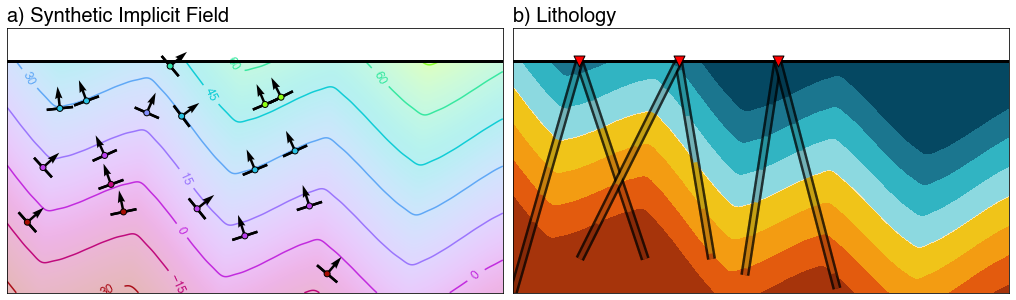

In [4]:
# Plot the model!
fig,ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True, layout="constrained")
pred = analytical_M.predict(gxy)
cid, labels = analytical_M.classify(gxy, return_vals=False)
classes = np.hstack([ h['classID'] for h in holes ]) # limit to classes in drillholes
vmn=np.min(classes)
vmx=np.max(classes)

# Define colormaps
sfield_cm = cmr.neon
colormap = curlew_cmap

# Plot the scalar field and the constraints
plot2D(pred[:, 0], grid_obj, ax=ax[0], cmap=sfield_cm)
plotConstraints(ax[0], C, ll=1.2, lw=0.005, scale=0.015, ac="k", vmn=None, vmx=vmx, cmap=sfield_cm)
# Plot the stratigraphy
plot2D(cid[:, 0], grid_obj, ax=ax[1],  levels=False, cmap=colormap, alpha=1)

# Set titles
ax[0].set_title("a) Synthetic Implicit Field", loc="left")
ax[1].set_title("b) Lithology", loc="left")

# Plot the drill holes
for hole in holes:
    plotDrill(hole, ax=ax[1], lw=4, ticksize=0, vmn=vmn, vmx=vmx, cmap=colormap)
    
ax[0].axhline(700, c="k", lw=3, zorder=9)
ax[1].axhline(700, c="k", lw=3, zorder=9)

ax[1].scatter(200, 700, s=120, marker="v", zorder=20, fc="r", ec="k")
ax[1].scatter(500, 700, s=120, marker="v", zorder=20, fc="r", ec="k")
ax[1].scatter(800, 700, s=120, marker="v", zorder=20, fc="r", ec="k")
    
# Make the plot prettier
_ = [ax_.set_xticks([]) for ax_ in ax]
_ = [ax_.set_aspect("equal") for ax_ in ax]
ax[0].set_ylim([0, dims[1]+100])
ax[0].set_xlim([0, dims[0]])
_ = [ax_.set_yticks([]) for ax_ in ax]

# show the figure!
plt.show()

### Set up the training regime

All models will use the same hyperparameters for all losses, the only difference will be the RNG seed.

In [5]:
# Number of epochs
nepochs = 500

# Define hyperparameter set
H_l = curlew.HSet()
H_l = H_l.zero(iq_loss="0.1", grad_loss="0.1", mono_loss="1", thick_loss="0.1")

# Model List
uncertainty_model_list = []
scale = [150, 1000]
random.seed(404)
# Get 25 seeds for 25 Models!
seed_values = random.sample(list(np.arange(100000)), k=25)

### Fit!
N.B.: This might take a while! To test the ensemble predictions, skip to the cell after the storing!

In [6]:
# Fit the models!
names = ['Seed Value = ' + str(seed) for seed in seed_values]

for i in range(len(seed_values)):
    print("Fitting %s"%names[i])
    # Get the HSet
    H = H_l

    # Initialise the interpolator
    nf0 = strati('basement', # name for this scalar field
                 C, # constraints for this field
                 H, # interpolator hyperparameters
                 base=-np.inf, # basal surface (important for unconformities)
                 input_dim=2, # field input coordinate dimensions (2D in our case)
                 hidden_layers=[512,], # hidden layers in the multi-layer perceptron that parameterises our field
                 rff_features=128, # number of random sin and cos features to create for each scale 
                 length_scales=scale, # the length scales in our model
                 seed=seed_values[i] # RNG seed
                )

    # Define Isosurfaces (also using contact points)
    for hole in holes:
        for p,n in zip(hole['contacts']['pos'], hole['contacts']['classID']):
            nf0.isosurfaces[ hole['className'][n] ] = nf0.isosurfaces.get(hole['className'][n],[]) + [p]    
        
    # Initialise a GeoModel object
    M = GeoModel([nf0]) 

    # Fit the model
    _ = M.prefit(epochs=nepochs, early_stop=None)
            
    # Store the model
    uncertainty_model_list.append(M)

Fitting Seed Value = 11461


basement: 500/500|, grad_loss=0.00335, thick_loss=0.0298, mono_loss=0.0543, iq_loss=0.00285


Fitting Seed Value = 53194


basement: 500/500|, grad_loss=0.00296, thick_loss=0.0236, mono_loss=0.0634, iq_loss=0.00207


Fitting Seed Value = 426


basement: 500/500|, grad_loss=0.00151, thick_loss=0.0713, mono_loss=0.405, iq_loss=0.108   


Fitting Seed Value = 67869


basement: 500/500|, grad_loss=0.000748, thick_loss=0.021, mono_loss=0.104, iq_loss=0.000827 


Fitting Seed Value = 12249


basement: 500/500|, grad_loss=0.00295, thick_loss=0.0253, mono_loss=0.103, iq_loss=0.00699 


Fitting Seed Value = 89344


basement: 500/500|, grad_loss=0.00397, thick_loss=0.0745, mono_loss=0.198, iq_loss=0.0248  


Fitting Seed Value = 78217


basement: 500/500|, grad_loss=0.0028, thick_loss=0.0342, mono_loss=0.121, iq_loss=0.000875 


Fitting Seed Value = 12481


basement: 500/500|, grad_loss=0.00287, thick_loss=0.0242, mono_loss=0.0569, iq_loss=0.00227


Fitting Seed Value = 43612


basement: 500/500|, grad_loss=0.00489, thick_loss=0.0101, mono_loss=0.0166, iq_loss=0.0107 


Fitting Seed Value = 17557


basement: 500/500|, grad_loss=0.0051, thick_loss=0.0312, mono_loss=0.114, iq_loss=0.00446 


Fitting Seed Value = 51907


basement: 500/500|, grad_loss=0.00353, thick_loss=0.0231, mono_loss=0.0728, iq_loss=0.00243


Fitting Seed Value = 13117


basement: 500/500|, grad_loss=0.00469, thick_loss=0.0375, mono_loss=0.0838, iq_loss=0.00244


Fitting Seed Value = 2797


basement: 500/500|, grad_loss=0.00258, thick_loss=0.0175, mono_loss=0.0358, iq_loss=0.00306


Fitting Seed Value = 85992


basement: 500/500|, grad_loss=0.00311, thick_loss=0.0366, mono_loss=0.0878, iq_loss=0.00286


Fitting Seed Value = 87524


basement: 500/500|, grad_loss=0.00105, thick_loss=0.0212, mono_loss=0.0596, iq_loss=0.00133 


Fitting Seed Value = 62912


basement: 500/500|, grad_loss=0.00211, thick_loss=0.0185, mono_loss=0.0862, iq_loss=0.00179


Fitting Seed Value = 11886


basement: 500/500|, grad_loss=0.00519, thick_loss=0.0252, mono_loss=0.0609, iq_loss=0.00989


Fitting Seed Value = 69735


basement: 500/500|, grad_loss=0.00523, thick_loss=0.0461, mono_loss=0.128, iq_loss=0.00378


Fitting Seed Value = 993


basement: 500/500|, grad_loss=0.0118, thick_loss=0.0904, mono_loss=0.464, iq_loss=0.00984


Fitting Seed Value = 23472


basement: 500/500|, grad_loss=0.00346, thick_loss=0.0176, mono_loss=0.0418, iq_loss=0.00606


Fitting Seed Value = 86444


basement: 500/500|, grad_loss=0.00431, thick_loss=0.0389, mono_loss=0.396, iq_loss=0.000756


Fitting Seed Value = 76757


basement: 500/500|, grad_loss=0.00297, thick_loss=0.0427, mono_loss=0.217, iq_loss=0.00246


Fitting Seed Value = 98276


basement: 500/500|, grad_loss=0.00238, thick_loss=0.0218, mono_loss=0.0523, iq_loss=0.00431


Fitting Seed Value = 86842


basement: 500/500|, grad_loss=0.00411, thick_loss=0.0322, mono_loss=0.076, iq_loss=0.00464 


Fitting Seed Value = 24079


basement: 500/500|, grad_loss=0.00276, thick_loss=0.052, mono_loss=0.151, iq_loss=0.0189  


In [7]:
# Store models!
_ = joblib.dump(uncertainty_model_list, "uncertainty_models_500_epochs.pkl")

### Jump here to use a pre-trained ensemble!

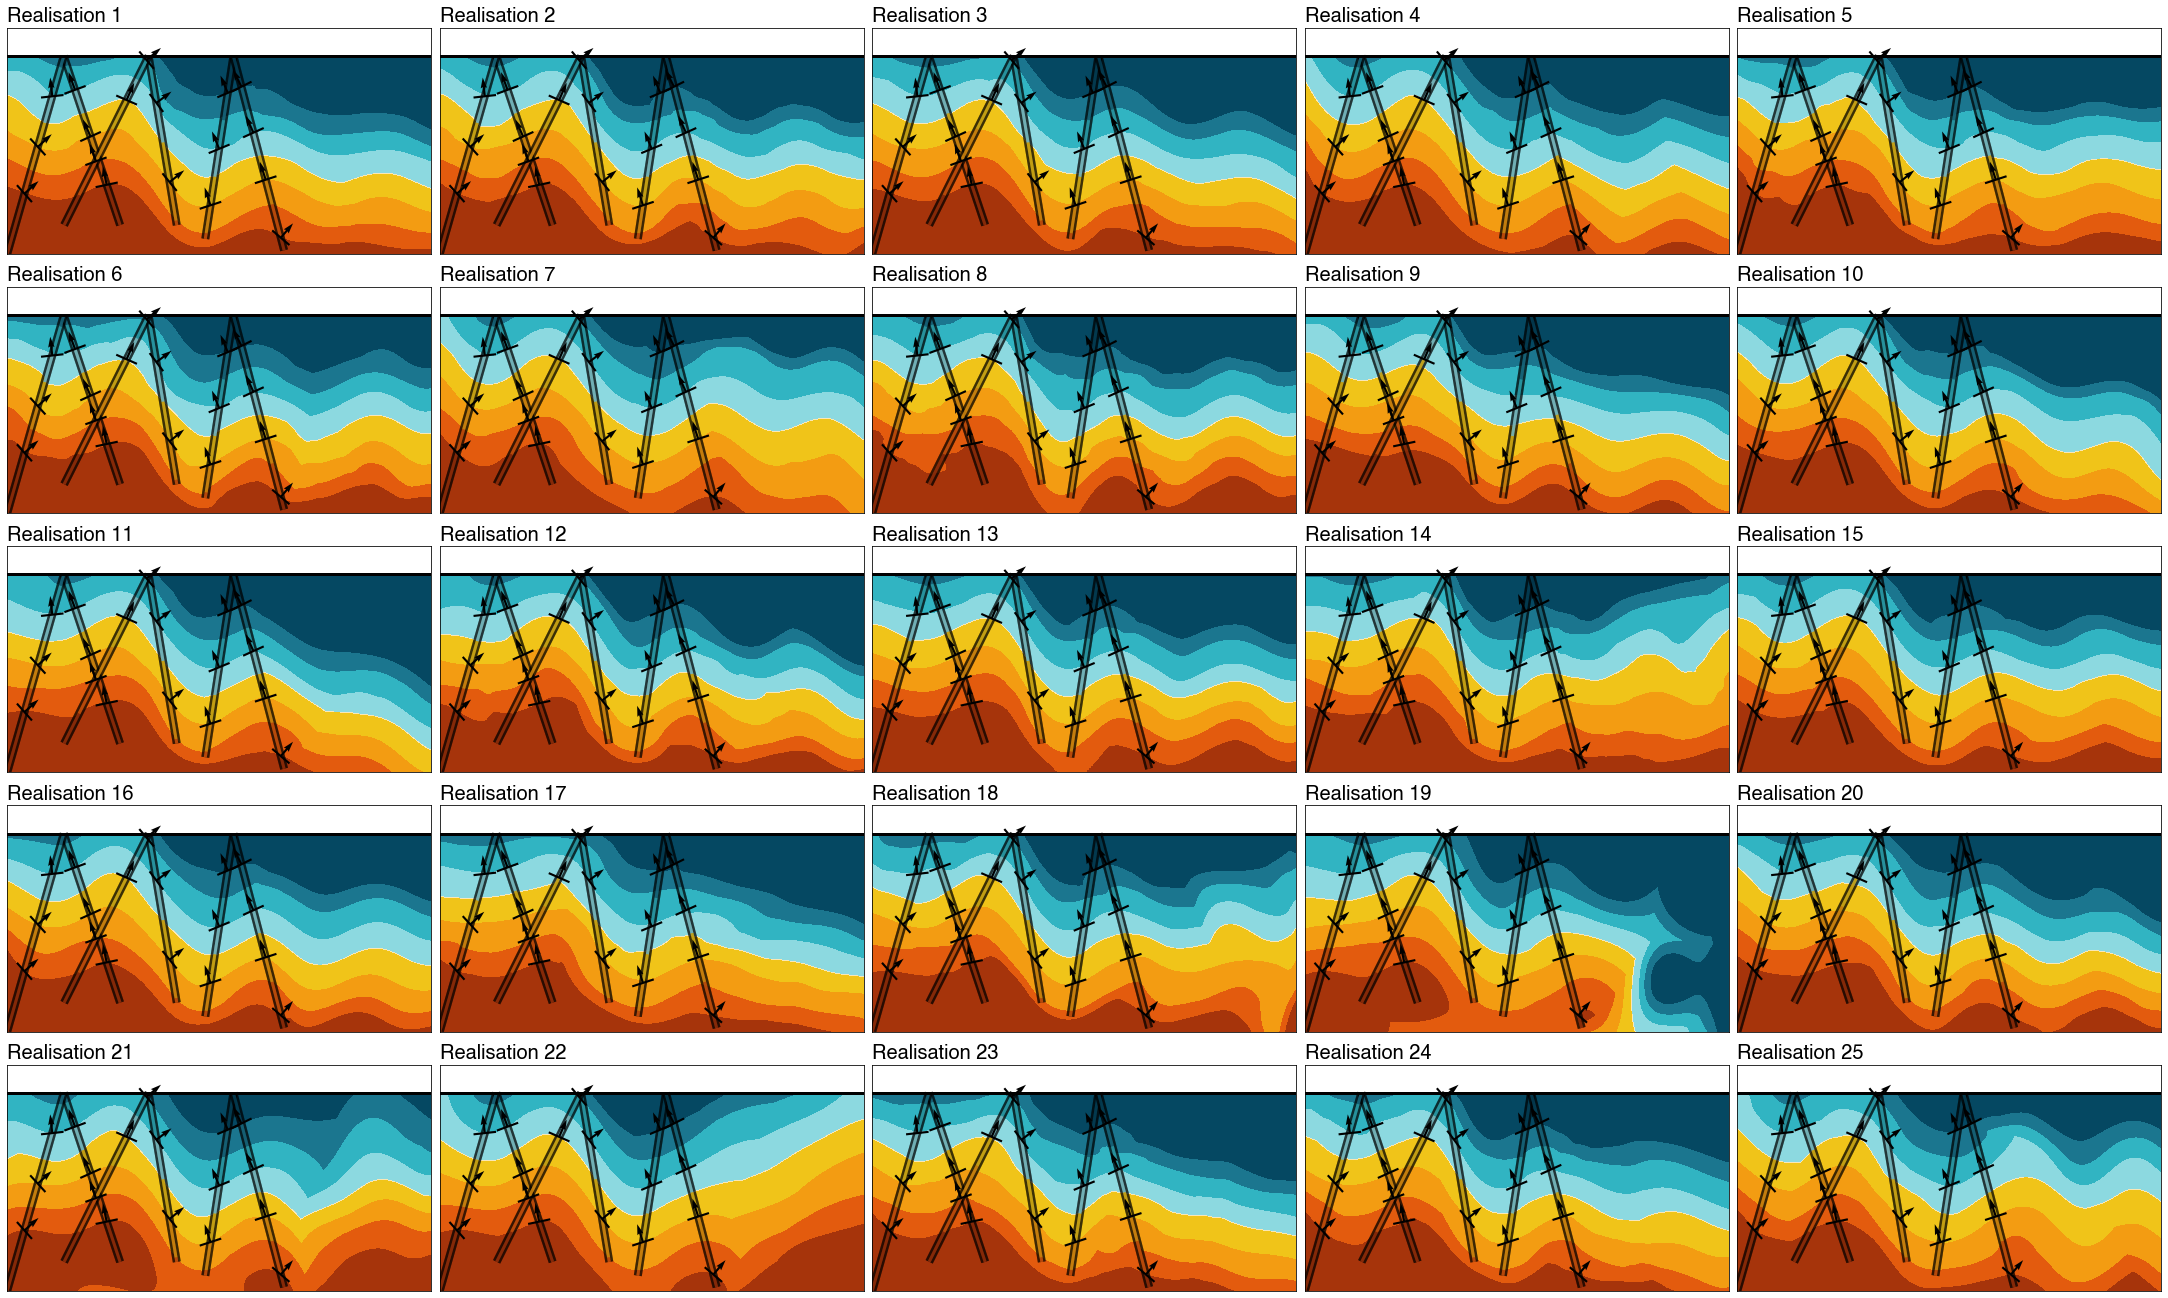

In [8]:
# All realisations
fig, ax = plt.subplots(5, 5, figsize=(30, 18), sharex=True, sharey=True, layout="constrained")
labels_ = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
uncertainty_model_list = joblib.load("uncertainty_models_500_epochs.pkl")

for i in range(len(uncertainty_model_list)):
    # Retrieve model
    M = uncertainty_model_list[i]
    H = H_l.copy()
    
    # Predict
    pred = M.predict(gxy)
    classes, _ = M.classify(gxy)

    # Plotting
    # Plot the drillholes
    for hole in holes:
        plotDrill(hole, ax=ax.ravel()[i], lw=3, ticksize=0, vmn=vmn, vmx=vmx, cmap=curlew_cmap)

    # Plot the stratigraphy
    plot2D(classes[:, 0], grid_obj, ax=ax.ravel()[i], levels=False, cmap=curlew_cmap, alpha=1)
    # Plot the constraints
    plotConstraints(ax.ravel()[i], C, H, ll=1.2, lw=0.005, scale=0.015, ac="k", vmn=None, vmx=np.max(classes), cmap=curlew_cmap)
    # Title
    ax.ravel()[i].set_title("Realisation " + str(i + 1), loc="left")
    # Surface line
    ax.ravel()[i].axhline(700, c="k", lw=3, zorder=9)
    
# Remove ticks to make plot pretty!
_ = [ax_.set_xticks([]) for ax_ in ax.ravel()]
_ = [ax_.set_yticks([]) for ax_ in ax.ravel()]
ax.ravel()[0].set_ylim([0, dims[1]+100])

plt.savefig("Model_Realisations_500_epochs.png", dpi=200)
plt.show()

### Shannon Entropy

To quantify the uncertainty of the models, we use Shannon Entropy. Applying it on pixel-wise realisations generated using multiple random seeds, we get a measure of the model's epistemic uncertainty.

In [9]:
import numpy as np
from scipy.stats import entropy

def pixelwise_entropy(class_maps):
    """
    Compute pixelwise entropy over a list of 2D classification maps.

    Parameters:
        class_maps (List[np.ndarray]): List of 2D numpy arrays of shape (H, W), each with class IDs.

    Returns:
        np.ndarray: 2D array of shape (H, W) with entropy values per pixel.
    """
    # Stack all class maps into a 3D array of shape (N, H, W)
    stacked = np.stack(class_maps, axis=0)  # shape: (N, H, W)

    # Flatten along the first axis to shape (H*W, N)
    N, H, W = stacked.shape
    pixels = stacked.transpose(1, 2, 0).reshape(-1, N)  # shape: (H*W, N)

    # Find the unique values and their counts per pixel
    unique_vals = np.unique(pixels)
    entropy_vals = np.zeros(pixels.shape[0], dtype=np.float32)

    for val in unique_vals:
        # Count how often `val` appears per pixel
        mask = pixels == val
        counts = np.sum(mask, axis=1)  # shape: (H*W,)
        probs = counts / N
        # Accumulate entropy (vectorized over all pixels)
        entropy_vals -= np.where(probs > 0, probs * np.log2(probs+1e-10), 0) # add 1e-10 to avoid log 0

    # Reshape back to (H, W)
    return entropy_vals.reshape(H, W)

In [10]:
# Generate and store realisations
realisations = []
for i in range(len(uncertainty_model_list)):
    # Retrieve model
    M = uncertainty_model_list[i]
    
    # Predict
    pred = M.predict(gxy)
    classes, _ = M.classify(gxy)
    
    realisations.append(classes[:, 0].reshape(dims))

In [11]:
# Compute the entropy
folds_entropy = pixelwise_entropy(realisations)

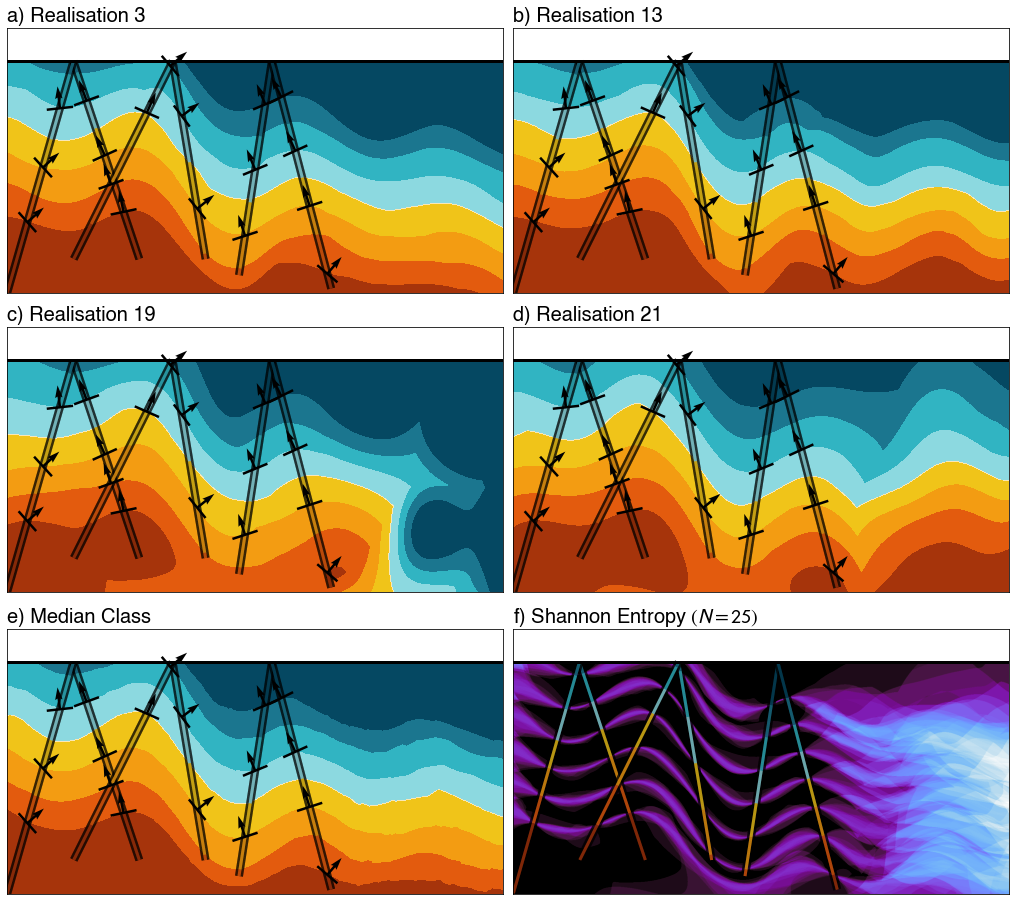

In [13]:
# Plot the stratigraphy
fig, ax = plt.subplots(3, 2, figsize=(14, 12.5), sharex=True, sharey=True, layout="constrained")
realisation_idxs = [2, 12, 18, 20]
labels_ = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) "]

for i in range(6):
    
    if i < 4:
        # Plot the realisation
        plot2D(realisations[realisation_idxs[i]], grid_obj, ax=ax.ravel()[i], levels=False, cmap=curlew_cmap, alpha=1)
        ax.ravel()[i].set_title(labels_[i] + "Realisation " + str(realisation_idxs[i] + 1), loc="left")
        # Plot the constraints
        plotConstraints(ax.ravel()[i], C, H, ll=1.2, lw=0.005, scale=0.015, ac="k", vmn=None, vmx=np.max(classes), cmap=curlew_cmap)
    elif i == 4:
        # Plot the median of the classifications
        median_class = np.round(np.median(np.stack(realisations), axis=0))
        plot2D(median_class, grid_obj, ax=ax.ravel()[i], levels=False, cmap=curlew_cmap, alpha=1)
        ax.ravel()[i].set_title(labels_[i] + "Median Class", loc="left")
        # Plot the constraints
        plotConstraints(ax.ravel()[i], C, H, ll=1.2, lw=0.005, scale=0.015, ac="k", vmn=None, vmx=np.max(classes), cmap=curlew_cmap)
    else:
        # Plot the realisation
        plot2D(folds_entropy.ravel(), grid_obj, ax=ax.ravel()[i], levels=False, cmap=cmr.voltage, alpha=1)
        ax.ravel()[i].set_title(labels_[i] + r"Shannon Entropy $(N = 25)$", loc="left")
        
    # Surface line
    for hole in holes:
        plotDrill(hole, ax=ax.ravel()[i], lw=3, ticksize=0, vmn=vmn, vmx=vmx, cmap=curlew_cmap)
        
    ax.ravel()[i].axhline(700, c="k", lw=3, zorder=9)
    # Remove ticks to make plot pretty!
    ax.ravel()[i].set_xticks([])
    ax.ravel()[i].set_yticks([])
    
    ax.ravel()[i].set_ylim([0, dims[1] + 100])

# Store the figure!
plt.savefig("Uncertainty_500_epochs.png", dpi=350)
plt.show()